In [45]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import time
from IPython import display
import imageio
import glob

from matplotlib.pylab import rcParams

In [2]:
os.makedirs(os.getenv('HOME')+ '/aiffel/dcgan_newimage/cifar10_v1/generated_samples')
os.makedirs(os.getenv('HOME')+ '/aiffel/dcgan_newimage/cifar10_v1/training_history')
os.makedirs(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10_v1/training_checkpoints')

# 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용할 train_x 의 이미지를 -1, 1로 정규화합니다.
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [4]:
print("max pixel:", train_x.max())
print("max pixel:", train_x.min())

max pixel: 255
max pixel: 0


In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 -1, 1 로 정규화

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


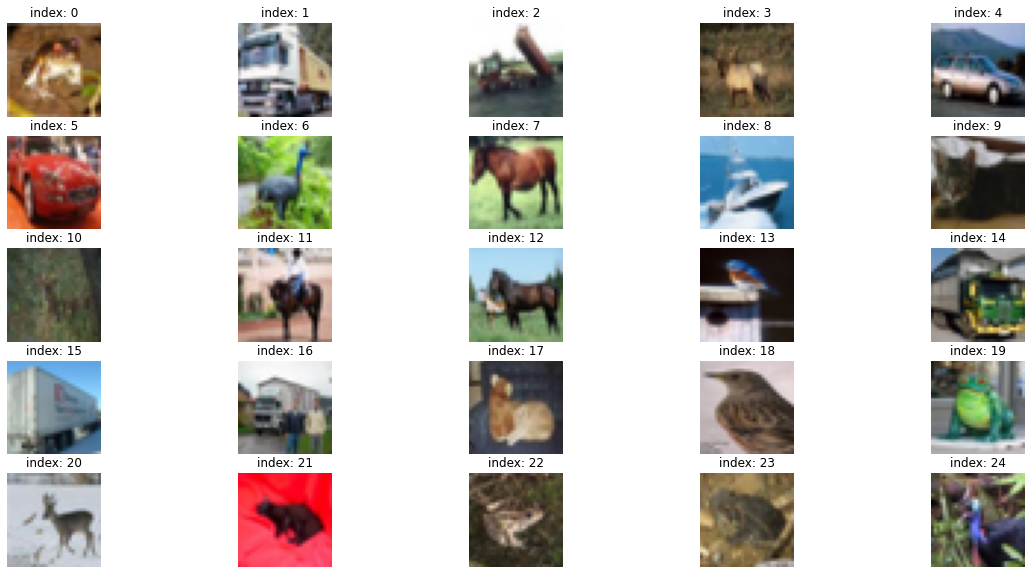

In [6]:
plt.figure(figsize=(20, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[i] + 1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델 구현하기

In [9]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layers
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
noise = tf.random.normal([1, 100])

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

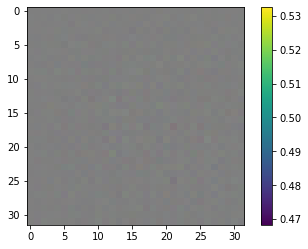

In [13]:
plt.imshow((generated_image[0] + 1)/ 2)
plt.colorbar()
plt.show()

# 판별자 모델 구현하기

In [14]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model
    

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00046801]], dtype=float32)>

# 손실함수와 최적화 함수 구현하기

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 상세 기능 구현하기

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_path):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow((predictions[i, :, :, ] + 1) / 2)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')
        
    plt.savefig(save_path.format(os.getenv('HOME'), epoch, it))
    plt.show()

In [25]:
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch, history_path):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig(history_path.format(os.getenv('HOME'), epoch))
    plt.show()

In [26]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10_v1/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# 학습 과정 진행하기

In [27]:
def train(dataset, epochs, save_every, save_path, history_path):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_path)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_path)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch, history_path)

In [28]:
save_every = 5
EPOCHS = 50

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

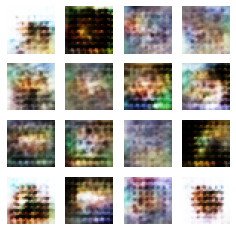

Time for training : 813 sec


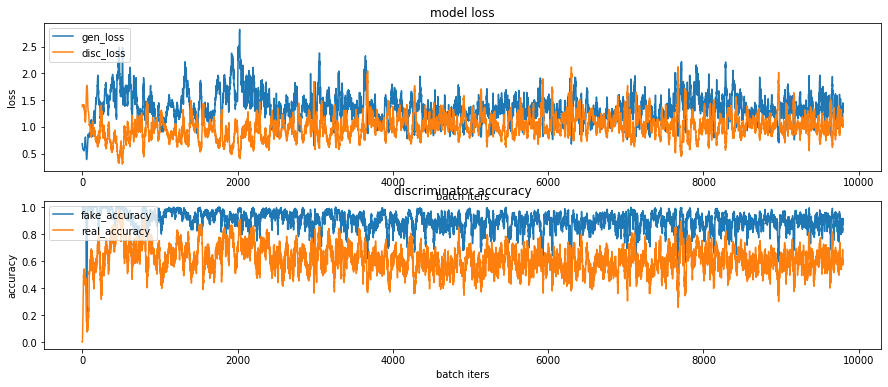

CPU times: user 13min 45s, sys: 1min 24s, total: 15min 9s
Wall time: 13min 34s


In [29]:
%%time
s_path = '{}/aiffel/dcgan_newimage/cifar10_v1/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
h_path = '{}/aiffel/dcgan_newimage/cifar10_v1/training_history/train_history_{:04d}.png'
train(train_dataset, EPOCHS, save_every, s_path, h_path)

In [30]:
# gif 생성.
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_v1/cifar10_v1_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_v1/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    #print(filenames)
    #image = imageio.imread(filenames)
    #writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_v1/cifar10_v1_dcgan.gif

-rw-r--r-- 1 root root 1041395 May  1 12:11 /aiffel/aiffel/dcgan_newimage/cifar10_v1/cifar10_v1_dcgan.gif


## GAN 훈련 과정 개선하기

이전 모델에서는 gen_loss 가 2.0 ~ 1.0, disc_loss 가 1.4 ~ 0.7  
fake_accuracy 1.0 ~ 0.8, real_accuracy 0.8 ~ 0.5 

* LeakyReLU() -> LeakyReLU(0.2)
* discriminator -> 마지막 dense layer activation='sigmoid'
* optimizer Adam learning_rate=1e-4 -> learning_rate=2e-4, beta1=0.5
* EPOCHS 50 -> 200

In [31]:
os.makedirs(os.getenv('HOME')+ '/aiffel/dcgan_newimage/cifar10_v2/generated_samples')
os.makedirs(os.getenv('HOME')+ '/aiffel/dcgan_newimage/cifar10_v2/training_history')
os.makedirs(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10_v2/training_checkpoints')

In [32]:
def make_generator_model_v2():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Fifth: Conv2DTranspose layers
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [33]:
generator_v2 = make_generator_model_v2()

generator_v2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [34]:
generated_image_v2 = generator_v2(noise, training=False)
generated_image_v2.shape

TensorShape([1, 32, 32, 3])

In [35]:
def make_discriminator_model_v2():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [36]:
discriminator_v2 = make_discriminator_model_v2()
discriminator_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [37]:
decision_v2 = discriminator_v2(generated_image_v2, training=False)
decision_v2

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49951968]], dtype=float32)>

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

In [39]:
@tf.function
def train_step_v2(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_v2(noise, training=True)
        
        real_output = discriminator_v2(images, training=True)
        fake_output = discriminator_v2(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_v2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_v2.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_v2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_v2.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [40]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10_v2/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator_v2,
                                discriminator=discriminator_v2)

In [41]:
def train(dataset, epochs, save_every, save_path, history_path):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_v2(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_v2, epoch+1, it+1, seed, save_path)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator_v2, epochs, it, seed, save_path)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch, history_path)

In [42]:
save_every = 5
EPOCHS = 200

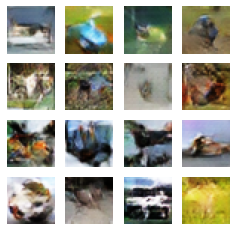

Time for training : 3412 sec


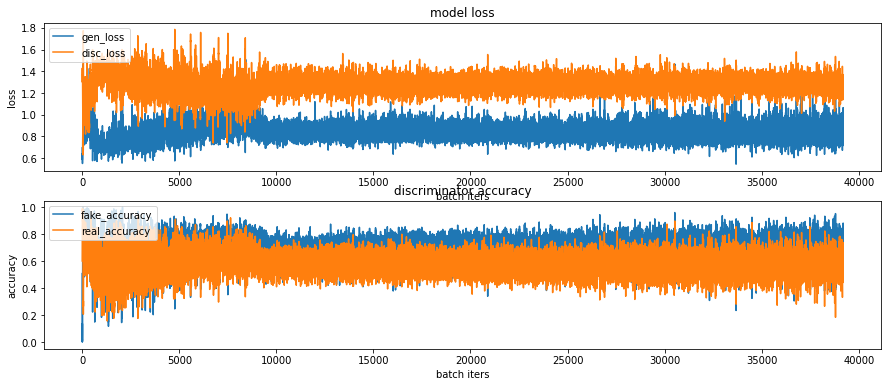

CPU times: user 57min 32s, sys: 5min 36s, total: 1h 3min 8s
Wall time: 56min 54s


In [43]:
%%time
s_path = '{}/aiffel/dcgan_newimage/cifar10_v2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
h_path = '{}/aiffel/dcgan_newimage/cifar10_v2/training_history/train_history_{:04d}.png'
train(train_dataset, EPOCHS, save_every, s_path, h_path)

In [44]:
# gif 생성.
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_v2/cifar10_v2_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_v2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    #print(filenames)
    #image = imageio.imread(filenames)
    #writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_v2/cifar10_v2_dcgan.gif

-rw-r--r-- 1 root root 1921912 May  1 13:08 /aiffel/aiffel/dcgan_newimage/cifar10_v2/cifar10_v2_dcgan.gif


---

In [49]:
df = pd.DataFrame({'Base': ['default', 'None', 1e-4, 'default', 50, '2.0 ~ 1.0', '1.4 ~ 0.7', '1.0 ~ 0.8', '0.8 ~ 0.5'],
                  'Change': [0.2, 'sigmoid', 2e-4, 0.5, 200, '1.0 ~ 0.7', '1.4 ~ 1.1', '0.9 ~ 0.5', '0.7 ~ 0.4']},
                 index = ['LeakyReLU alpha', 'disc dense layer activation', 'optimizer Adam lr', 'optimizer Adam beta1', 'epochs', 'gen_loss', 'disc_loss', 'fake_acc', 'real_acc'])
df

,Base,Change
LeakyReLU alpha,default,0.2
disc dense layer activation,None,sigmoid
optimizer Adam lr,0.0001,0.0002
optimizer Adam beta1,default,0.5
epochs,50,200
gen_loss,2.0 ~ 1.0,1.0 ~ 0.7
disc_loss,1.4 ~ 0.7,1.4 ~ 1.1
fake_acc,1.0 ~ 0.8,0.9 ~ 0.5
real_acc,0.8 ~ 0.5,0.7 ~ 0.4


* 표의 위 5가지 파라미터를 변경했을 때, 아래 4가지 값들이 해당값 처럼 변경되었습니다.
* gen_loss가 감소하였고, disc_loss는 조금 상승하였으며, fake_acc는 평균적으로 하락하여 비교적 0.5에 가까워졌고, real_acc는 소폭 하락하였습니다.

![sample_epoch_0200_iter_195](https://user-images.githubusercontent.com/119499530/235464982-af855ee8-b27b-4818-9b91-85fcd0638088.png)


맨밑 3번째 그림이 그나마 자동차 비슷하게 나온거 같습니다.

![cifar10_v2_dcgan](https://user-images.githubusercontent.com/119499530/235465126-7bdc4027-bb1a-4991-8a0b-9842c5c5dbf2.gif)

gif의 변화에 따라 서서히 윤곽이 잡히기 시작하는것 같습니다.

### 번외. epochs 500 test + batch_size = 128

![화면 캡처 2023-05-01 214503](https://user-images.githubusercontent.com/119499530/235468849-ace69e7e-6946-446d-820e-5f56c55d9047.png)

* gen_loss 는 점점 증가하고, real_acc는 점점 안정화되고 있습니다.

![sample_epoch_0500_iter_390](https://user-images.githubusercontent.com/119499530/235468487-3c780853-a16b-4671-8f0f-65ee36b0689c.png)

![cifar10_v2_dcgan (2)](https://user-images.githubusercontent.com/119499530/235468720-3b1a409c-a7bf-4ce3-aa4e-c0b3f99c2ce8.gif)

* 어느정도 그림의 윤곽이 잡히면서 잘 그려지나 싶더니 다시 이상한 형태로 변하네요.

# 회고

* 파라미터를 다양하게 주고 모델의 층도 이리저리 추가하고 빼보면서 모델들을 돌려봤지만, 아무래도 이미지들의 특성에 평균적인 형태의 이미지를 출력해내는 것이다보니 원래 타겟의 형태를 찾아보기가 쉽지 않게 그림이 나오는것 같습니다.
* epochs 500까지도 돌려보았지만 너무 많이 학습해서 그런지 오히려 더 형태를 알아볼 수 없는 상태까지 갔지만 정확도는 오르는것을 보고 제대로 한게 맞는지 애매한 기분이 들었습니다.
* 여러 테스트를 해보면서 나오는 이미지들을 보다보니, 잘 훈련된 모델의 결과물은 어떤 형태의 이미지를 보여줄지 아니면 어떤 이미지가 좋은 결과를 보여줄 수 있는 모델의 이미지인지가 궁금해지는 프로젝트 였습니다.



### 참고
https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/  
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/